[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alexj-smolin/ds-school/blob/main/part4/HW3_2.ipynb)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
dataset = datasets.MNIST('.', download=True)

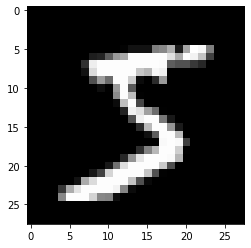

In [3]:
plt.imshow(np.array(dataset[0][0]), cmap='gray');

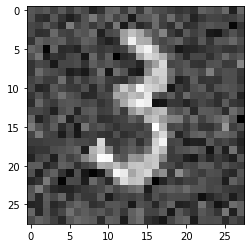

In [4]:
import matplotlib.pyplot as plt
noized = dataset.data[1234].float() / 255 + torch.normal(
    torch.zeros_like(dataset.data[1234].float()), 
    0.2 * torch.ones_like(dataset.data[1234].float()))
plt.imshow(noized.detach().numpy(), cmap='gray')
plt.show()

In [5]:
def show_img(im_true, im_pred):
    _, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(im_true, cmap='gray')
    ax[0].set_axis_off()
    ax[1].imshow(im_pred, cmap='gray')
    ax[1].set_axis_off()
    plt.show()

In [6]:
# hyperparams
latent_size = 64
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 12
batch_size = 128
noise_factor = 0.4

In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.c1 = self._conv_half(1, latent_size // 8) # 28x28 -> 14x14
        self.c2 = self._conv_half(latent_size // 8, latent_size // 4) # 14x14 -> 7x7
        self.c3 = self._conv_half(latent_size // 4, latent_size // 2) # 7x7 -> 3x3
        self.c4 = self._conv_half(latent_size // 2, latent_size) # 3x3 -> 1x1

    def _conv_half(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(out_ch)
        )

    def forward(self, x):
        x = self.c1(x)
        x = self.c2(x)
        x = self.c3(x)
        x = self.c4(x)
        return x.reshape(len(x), -1)


class Decoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.d1 = self._deconv_dbl(latent_size, latent_size // 2, (3, 3)) # 1x1 -> 3x3
        self.d2 = self._deconv_dbl(latent_size // 2, latent_size // 4, (7, 7)) # 3x3 -> 7x7
        self.d3 = self._deconv_dbl(latent_size // 4, latent_size // 8) # 7x7 -> 14x14
        self.d4 = self._deconv_dbl(latent_size // 8, 1, act=False) # 14x14 -> 28x28

    def _deconv_dbl(self, in_ch, out_ch, output_size=None, act=True):
        deconv = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1)
        if output_size:
            deconv = self.AdjConvT2d(deconv, output_size)
        if not act:
            return nn.Sequential(deconv)
        return nn.Sequential(
            deconv,
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(out_ch)
        )

    class AdjConvT2d(nn.Module):
        def __init__(self, conv, output_size):
            super().__init__()
            self.conv = conv
            self.output_size = output_size
        def forward(self, x):
            return self.conv(x, output_size=self.output_size)
    
    def forward(self, x):
        x = x[:, :, None, None]
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        x = self.d4(x)
        return x

    
class HWAutoEncoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(latent_size)

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [8]:
def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(np.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(np.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(np.array(target))

  return {
      'data': pics.unsqueeze(1), # B x 1 x W x H
      'target': target.long(),
      }

In [9]:
model_conv = HWAutoEncoder(latent_size).to(device)
optim = torch.optim.AdamW(model_conv.parameters(), lr=1e-2)
sched = torch.optim.lr_scheduler.StepLR(optim, 3, 0.3, verbose=True)
loss_func = nn.MSELoss()

Adjusting learning rate of group 0 to 1.0000e-02.


epoch: 0, step: 0, loss: 0.776930034160614
epoch: 0, step: 200, loss: 0.020949771627783775
epoch: 0, step: 400, loss: 0.017001789063215256


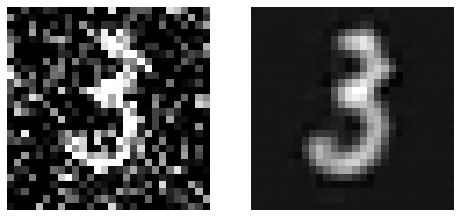

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 1, step: 0, loss: 0.016299493610858917
epoch: 1, step: 200, loss: 0.013520440086722374
epoch: 1, step: 400, loss: 0.013159364461898804


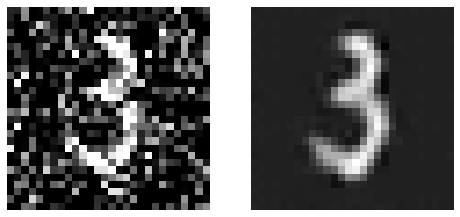

Adjusting learning rate of group 0 to 1.0000e-02.
epoch: 2, step: 0, loss: 0.013200439512729645
epoch: 2, step: 200, loss: 0.012137031182646751
epoch: 2, step: 400, loss: 0.011013585142791271


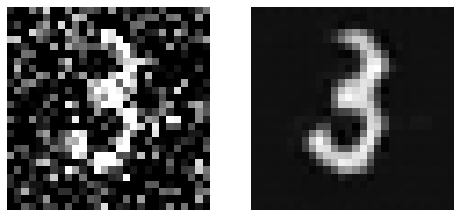

Adjusting learning rate of group 0 to 3.0000e-03.
epoch: 3, step: 0, loss: 0.010161340236663818
epoch: 3, step: 200, loss: 0.010737484320998192
epoch: 3, step: 400, loss: 0.0103294113650918


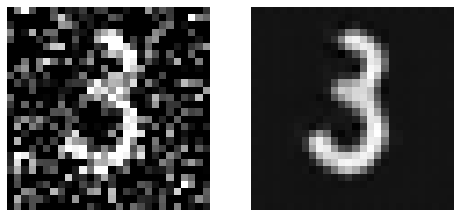

Adjusting learning rate of group 0 to 3.0000e-03.
epoch: 4, step: 0, loss: 0.010368971154093742
epoch: 4, step: 200, loss: 0.010491820052266121
epoch: 4, step: 400, loss: 0.010019727982580662


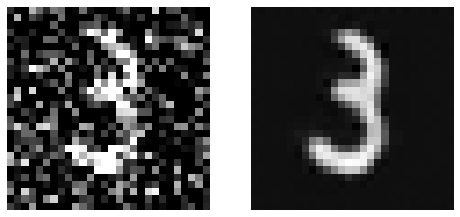

Adjusting learning rate of group 0 to 3.0000e-03.
epoch: 5, step: 0, loss: 0.010464799590408802
epoch: 5, step: 200, loss: 0.0102362846955657
epoch: 5, step: 400, loss: 0.010101212188601494


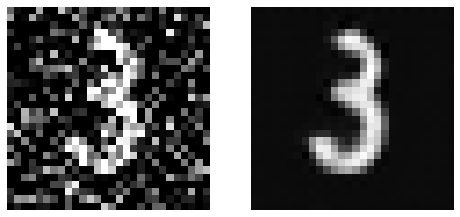

Adjusting learning rate of group 0 to 9.0000e-04.
epoch: 6, step: 0, loss: 0.009710238315165043
epoch: 6, step: 200, loss: 0.009102819487452507
epoch: 6, step: 400, loss: 0.008901513181626797


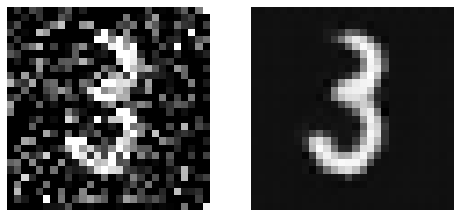

Adjusting learning rate of group 0 to 9.0000e-04.
epoch: 7, step: 0, loss: 0.009928891435265541
epoch: 7, step: 200, loss: 0.009682519361376762
epoch: 7, step: 400, loss: 0.009615358896553516


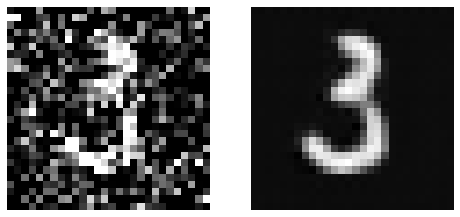

Adjusting learning rate of group 0 to 9.0000e-04.
epoch: 8, step: 0, loss: 0.009392746724188328
epoch: 8, step: 200, loss: 0.0098480936139822
epoch: 8, step: 400, loss: 0.009815982542932034


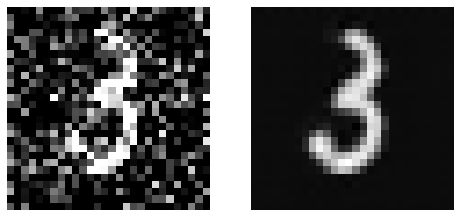

Adjusting learning rate of group 0 to 2.7000e-04.
epoch: 9, step: 0, loss: 0.009196242317557335
epoch: 9, step: 200, loss: 0.009333369322121143
epoch: 9, step: 400, loss: 0.009834338910877705


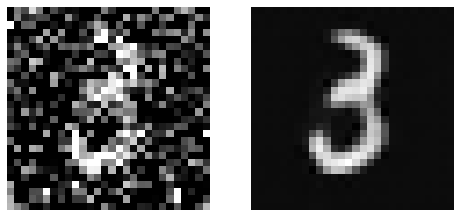

Adjusting learning rate of group 0 to 2.7000e-04.
epoch: 10, step: 0, loss: 0.008826539851725101
epoch: 10, step: 200, loss: 0.009318829514086246
epoch: 10, step: 400, loss: 0.008864197880029678


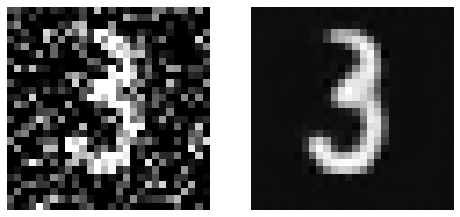

Adjusting learning rate of group 0 to 2.7000e-04.
epoch: 11, step: 0, loss: 0.00947563722729683
epoch: 11, step: 200, loss: 0.008880394510924816
epoch: 11, step: 400, loss: 0.00907092448323965


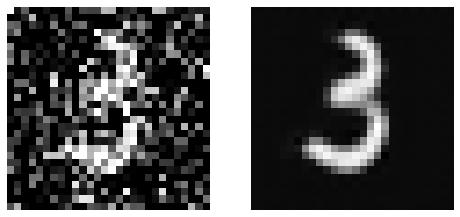

Adjusting learning rate of group 0 to 8.1000e-05.


In [10]:
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
  model_conv.train()
  for i, batch in enumerate(dataloader):
    optim.zero_grad()
    data = batch['data'].to(device)
    noized = torch.clamp(data + 
                         torch.normal(torch.zeros_like(data), 
                                      noise_factor * torch.ones_like(data)), 0., 1.)
    predict = model_conv(noized)
    loss = loss_func(predict, data)
    loss.backward()
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')

  model_conv.eval()
  item = dataset.data[1234].unsqueeze(0).unsqueeze(0).float() / 255
  item = torch.clamp(item + 
                     torch.normal(torch.zeros_like(item), 
                                  noise_factor * torch.ones_like(item)), 0., 1.)
  pred = model_conv(item.to(device))
  show_img(
      item.squeeze().cpu().detach().numpy(),
      pred.squeeze().cpu().detach().numpy()
  )

  sched.step()

  torch.save(model_conv.state_dict(), f'./conv_ae_chkpt_conv_{epoch}.pth')